# Description

Explore research backtest results.

**Note**: use `dataflow/model/notebooks/Master_backtest_analysis_param_sweep.ipynb` for standard backtest analysis.
This notebook is used for free-form analysis and hypotheses testing, and thus is not as strictly maintained.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import logging

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hparquet as hparque
import helpers.hprint as hprint
import oms.broker.ccxt.ccxt_utils as obccccut
import optimizer.forecast_evaluator_with_optimizer as ofevwiop

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-b5b51e3e-831d-45dc-a5f2-2688600ee9e2.json'
INFO  # Git
  branch_name='CmTask8217_Run_C11a_backtest_with_Optimizer'
  hash='7cf45e108'
  # Last commits:
    *   7cf45e108 Dan      Merge branch 'master' into CmTask8217_Run_C11a_backtest_with_Optimizer (25 minutes ago) Wed May 22 15:58:58 2024  (HEAD -> CmTask8217_Run_C11a_backtest_with_Optimizer, origin/CmTask8217_Run_C11a_backtest_with_Optimizer)
    |\  
    | * 8fc8f6717 Vedanshu Joshi CmTask8341 check in trading dags (#8348)                          (68 minutes ago) Wed May 22 15:15:53 2024  (origin/master, origin/HEAD, master)
    * | c489e3884 Dan      Merge branch 'master' into CmTask8217_Run_C11a_backtest_with_Optimizer (   2 hours ago) Wed May 22 14:42:02 2024           
    |\| 
# Machine info
  system=Linux
  node name=9936f79c29b9
  release=5.15.0-1056-aws
  version=#61~20.04.1-Ubuntu SMP Wed Mar 13 17:40:41 UTC 2

# Build the config dict

In [4]:
# Get config from env when running the notebook via the `run_notebook.py` script.
default_config = cconfig.get_config_from_env()
if default_config:
    _LOG.info("Using config from env vars")
else:
    _LOG.info("Using hardwired config")
    # Build default config.
    # amp_dir = hgit.get_amp_abs_path()
    dir_name = "/shared_data/CmTask8217/build_tile_configs.C11a.ccxt_v8_1-all.5T.2023-08-01_2024-05-22.ins.run0/tiled_results"
    # Create a subfolder to store portfolio metrics.
    # The subfolder is marked by the datetime of the run, e.g.
    # "build_tile_configs.C11a.ccxt_v8_1-all.5T.2023-01-01_2024-03-20.ins.run0/portfolio_dfs/20240326_131724".
    # TODO(Danya): Factor out into a function.
    default_config_dict = {
        "dir_name": dir_name,
        "start_date": datetime.date(2023, 8, 1),
        "end_date": datetime.date(2024, 5, 22),
        "asset_id_col": "asset_id",
        "pnl_resampling_frequency": "D",
        "rule": "5T",
        "im_client_config": {
            "vendor": "ccxt",
            "universe_version": "v8.1",
            "root_dir": "s3://cryptokaizen-data.preprod/v3",
            "partition_mode": "by_year_month",
            "dataset": "ohlcv",
            "contract_type": "futures",
            "data_snapshot": "",
            "aws_profile": "ck",
            "version": "v1_0_0",
            "download_universe_version": "v8",
            "tag": "downloaded_1min",
            "download_mode": "periodic_daily",
            "downloading_entity": "airflow",
            "resample_1min": False,
        },
        "annotate_forecasts_kwargs": {
            "quantization": 30,
            "liquidate_at_end_of_day": False,
            "initialize_beginning_of_day_trades_to_zero": False,
            "burn_in_bars": 3,
            "compute_extended_stats": True,
        },
        "forecast_evaluator_kwargs": {
            "price_col": "open",
            "volatility_col": "garman_klass_vol",
            "prediction_col": "feature",
            "optimizer_config_dict": {
                "dollar_neutrality_penalty": 0.0,
                "constant_correlation": 0.5,
                "constant_correlation_penalty": 50.0,
                "relative_holding_penalty": 0.0,
                "relative_holding_max_frac_of_gmv": 0.1,
                "target_gmv": 100000.0,
                "target_gmv_upper_bound_penalty": 0.0,
                "target_gmv_hard_upper_bound_multiple": 1.05,
                "transaction_cost_penalty": 0.5,
                "solver": "ECOS",
                "verbose": False,
            },
        },
        "bin_annotated_portfolio_df_kwargs": {
            "proportion_of_data_per_bin": 0.2,
            "normalize_prediction_col_values": False,
        },
        "load_all_tiles_in_memory": True,
        "sweep_param": {
            "keys": (
                "column_names",
                "price_col",
            ),
            "values": [
                "open",
            ],
        },
    }
    # Add asset_id_to_share_decimals based on the `quantization` parameter.
    if not default_config_dict["annotate_forecasts_kwargs"]["quantization"]:
        asset_id_to_share_decimals = obccccut.get_asset_id_to_share_decimals(
            "amount_precision"
        )
        default_config_dict["annotate_forecasts_kwargs"][
            "asset_id_to_share_decimals"
        ] = asset_id_to_share_decimals
    else:
        default_config_dict["annotate_forecasts_kwargs"][
            "asset_id_to_share_decimals"
        ] = None
    # Build config from dict.
    default_config = cconfig.Config().from_dict(default_config_dict)
print(default_config)

INFO  Using hardwired config
dir_name: /shared_data/CmTask8217/build_tile_configs.C11a.ccxt_v8_1-all.5T.2023-08-01_2024-05-22.ins.run0/tiled_results
start_date: 2023-08-01
end_date: 2024-05-22
asset_id_col: asset_id
pnl_resampling_frequency: D
rule: 5T
im_client_config: 
  vendor: ccxt
  universe_version: v8.1
  root_dir: s3://cryptokaizen-data.preprod/v3
  partition_mode: by_year_month
  dataset: ohlcv
  contract_type: futures
  data_snapshot: 
  aws_profile: ck
  version: v1_0_0
  download_universe_version: v8
  tag: downloaded_1min
  download_mode: periodic_daily
  downloading_entity: airflow
  resample_1min: False
annotate_forecasts_kwargs: 
  quantization: 30
  liquidate_at_end_of_day: False
  initialize_beginning_of_day_trades_to_zero: False
  burn_in_bars: 3
  compute_extended_stats: True
  asset_id_to_share_decimals: None
forecast_evaluator_kwargs: 
  price_col: open
  volatility_col: garman_klass_vol
  prediction_col: feature
  optimizer_config_dict: 
    dollar_neutrality_pen

# Load tiled results

## Report tile stats

In [5]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    default_config["dir_name"]
)

In [6]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1020313424,2,10,10,59.7 MB
1106736216,2,10,10,59.9 MB
1669260535,2,10,10,60.1 MB
1670436375,2,10,10,59.3 MB
1775391824,2,10,10,59.3 MB
1813442534,2,10,10,60.1 MB
1871387621,2,10,10,58.9 MB
2200033667,2,10,10,59.2 MB
2237530510,2,10,10,58.9 MB


In [7]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

n_asset_ids      size
year month                       
2023 8               25  154.9 MB
     9               25  150.1 MB
     10              25  155.5 MB
     11              25  151.0 MB
     12              25  156.2 MB
2024 1               25  156.3 MB
     2               25  146.5 MB
     3               25  156.3 MB
     4               25  151.6 MB
     5               25  106.4 MB

In [8]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1020313424,
 1106736216,
 1669260535,
 1670436375,
 1775391824,
 1813442534,
 1871387621,
 2200033667,
 2237530510,
 2470395105,
 2499295598,
 2506553600,
 2565005155,
 2601760471,
 2971863517,
 2989693852,
 3304664847,
 3323452427,
 3326458212,
 4417972573,
 5141755262,
 6009830573,
 6335759645,
 8717633868,
 8968126878]

## Load tile data

In [9]:
if default_config["load_all_tiles_in_memory"]:
    asset_ids_to_load = asset_ids
else:
    asset_ids_to_load = asset_ids[0:1]
asset_batch_size = len(asset_ids_to_load)
cols = None
#
asset_tile = next(
    hparque.yield_parquet_tiles_by_assets(
        default_config["dir_name"],
        asset_ids_to_load,
        default_config["asset_id_col"],
        asset_batch_size,
        cols,
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
tile_df = dtfmod.process_parquet_read_df(
    asset_tile, default_config["asset_id_col"]
)

In [11]:
tile_df.columns.levels[0].to_list()

['close',
 'close_mean',
 'feature',
 'garman_klass_vol',
 'high',
 'low',
 'month',
 'open',
 'p1',
 'p1.c',
 'p1.c.xs_adj',
 'p1.c.xs_adj.c',
 'p2',
 'p2.c',
 'p2.c.xs_adj',
 'p2.c.xs_adj.c',
 'p3',
 'p_diff',
 'p_diff.c',
 'p_diff.c.xs_adj',
 'p_diff.c.xs_adj.c',
 'p_est_mean',
 'p_lr',
 'p_lr.c',
 'p_lr.c.xs_adj',
 'p_lr.c.xs_adj.c',
 'q1',
 'q1.c',
 'q1.c.xs_adj',
 'q1.c.xs_adj.c',
 'q2',
 'q2.c',
 'q2.c.xs_adj',
 'q2.c.xs_adj.c',
 'q3',
 'q3.c',
 'q3.c.xs_adj',
 'q3.c.xs_adj.c',
 'q4',
 'q5',
 'q6',
 'q_mv',
 'q_mv_adj',
 'q_mv_os',
 'r1',
 'r1.c',
 'r1.c.xs_adj',
 'r1.c.xs_adj.c',
 'r2',
 'r2.c',
 'r2.c.xs_adj',
 'r2.c.xs_adj.c',
 'r3',
 'r4',
 'r4.c',
 'r4.c.xs_adj',
 'r4.c.xs_adj.c',
 'r5',
 'r5.c',
 'r5.c.xs_adj',
 'r5.c.xs_adj.c',
 'r6',
 'r6.c',
 'r6.c.xs_adj',
 'r6.c.xs_adj.c',
 'r_est',
 'r_est.c',
 'r_est.c.xs_adj',
 'r_est.c.xs_adj.c',
 'r_lr',
 'r_lr.c',
 'r_lr.c.xs_adj',
 'r_lr.c.xs_adj.c',
 'sqrt_q_mv',
 'sqrt_q_mv_adj',
 'sqrt_q_mv_os',
 'v_ld',
 'v_ld.c',
 'v_ld.c.

In [12]:
tile_df.head(3)

close                                                                                                                                                                                                                                                                         close_mean                                                                                                                                                                                                                                                                            feature                                                                                                                                                                                                                                                                         garman_klass_vol                                                                                                                           \
asset_id                  1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878       1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600   
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2023-08-01 00:00:00+00:00     1.6130     0.7648     1.7489      9.534     0.4415    0.11019     1225.1      12.15     23.716     161.19    0.08043      7.863     0.5876      7.546      0.978     0.7257     247.80     18.481     0.6317     1.8451     1.1689     2.3152      4.213     12.806     241.04    1.61300    0.76488    1.74852     9.5374    0.44150   0.110148    1225.30     12.146    23.7024    161.138   0.080396     7.8572    0.58716     7.5426     0.9780    0.72646    247.782    18.4778    0.63092    1.84472    1.16854    2.31648     4.2100    12.8036    241.012  -0.301949  -0.901440   1.308955   0.317432   0.337896   0.632775   0.099613  -0.107379  -0.762267   0.852035  -0.192151   0.128664   0.170291   0.083392  -0.766978  -0.436677   0.746936   0.724537  -1.126864   0.511364   0.489773  -0.128054  -2.895945   0.886257   0.574046         0.001383   0.002310   0.001131   0.000985   0.001039   0.001339   0.001646   0.001046   0.001697   0.001706   0.000699   0.001329   
2023-08-01 00:05:00+00:00     1.6099     0.7620     1.7456     

# Compute and save portfolio bar metrics

In [13]:
# Get configs sweeping over parameter.
config_dict = dtfmod.build_research_backtest_analyzer_config_sweep(default_config)
print(config_dict.keys())

dict_keys(['column_names:price_col = open'])


In [14]:
# If NaNs in the feature column are found, replace them with 0.
feature_col = default_config["forecast_evaluator_kwargs"]["prediction_col"]
feature_col_nans = tile_df[feature_col].isna().sum()
if feature_col_nans.sum():
    _LOG.warning("NaN values in the feature column:\n%s", feature_col_nans)
    tile_df[feature_col] = tile_df[feature_col].fillna(0)

WARNING NaN values in the feature column:
asset_id
1020313424     3
1106736216     3
1669260535     3
1670436375     6
1775391824    17
1813442534     3
1871387621     3
2200033667    30
2237530510     3
2470395105     3
2499295598     3
2506553600     3
2565005155     3
2601760471     3
2971863517    14
2989693852    11
3304664847     3
3323452427     3
3326458212     3
4417972573     3
5141755262     3
6009830573     3
6335759645    10
8717633868     3
8968126878     3
dtype: int64


In [15]:
portfolio_df_dict = {}
bar_metrics_dict = {}
for key, config in config_dict.items():
    if config["load_all_tiles_in_memory"]:
        fep = ofevwiop.ForecastEvaluatorWithOptimizer(
            **config["forecast_evaluator_kwargs"].to_dict(),
        )
        portfolio_df, bar_metrics = fep.annotate_forecasts(
            tile_df,
            **config["annotate_forecasts_kwargs"].to_dict(),
        )
    else:
        portfolio_df, bar_metrics = dtfmod.annotate_forecasts_by_tile(
            config["dir_name"],
            config["start_date"],
            config["end_date"],
            config["asset_id_col"],
            config["forecast_evaluator_kwargs"]["price_col"],
            config["forecast_evaluator_kwargs"]["volatility_col"],
            config["forecast_evaluator_kwargs"]["prediction_col"],
            asset_ids=None,
            annotate_forecasts_kwargs=config[
                "annotate_forecasts_kwargs"
            ].to_dict(),
            return_portfolio_df=True,
        )
    portfolio_df_dict[key] = portfolio_df
    bar_metrics_dict[key] = bar_metrics
portfolio_stats_df = pd.concat(bar_metrics_dict, axis=1)
portfolio_stats_df.tail(3)

  0%|          | 0/84961 [00:00<?, ?it/s]

WARNING problem.status=optimal_inaccurate


/venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


column_names:price_col = open                                                                          
                                                    pnl   gross_volume    net_volume            gmv           nmv   gpc  npc  wnl
2024-05-21 23:50:00+00:00                    -46.162407   89223.397933 -18554.631231  105025.359330 -33398.579291  25.0 -1.0 -5.0
2024-05-21 23:55:00+00:00                    -15.335385   78317.884519  14631.741038  104911.214220 -18782.173637  25.0 -1.0 -5.0
2024-05-22 00:00:00+00:00                    116.150535  119227.015323  29546.258663  105050.003267  10880.235560  25.0  3.0 -1.0

In [16]:
# Drop level with the col_name label so that we remove the label from the plots.
portfolio_stats_df = portfolio_stats_df.droplevel(0, axis=1)

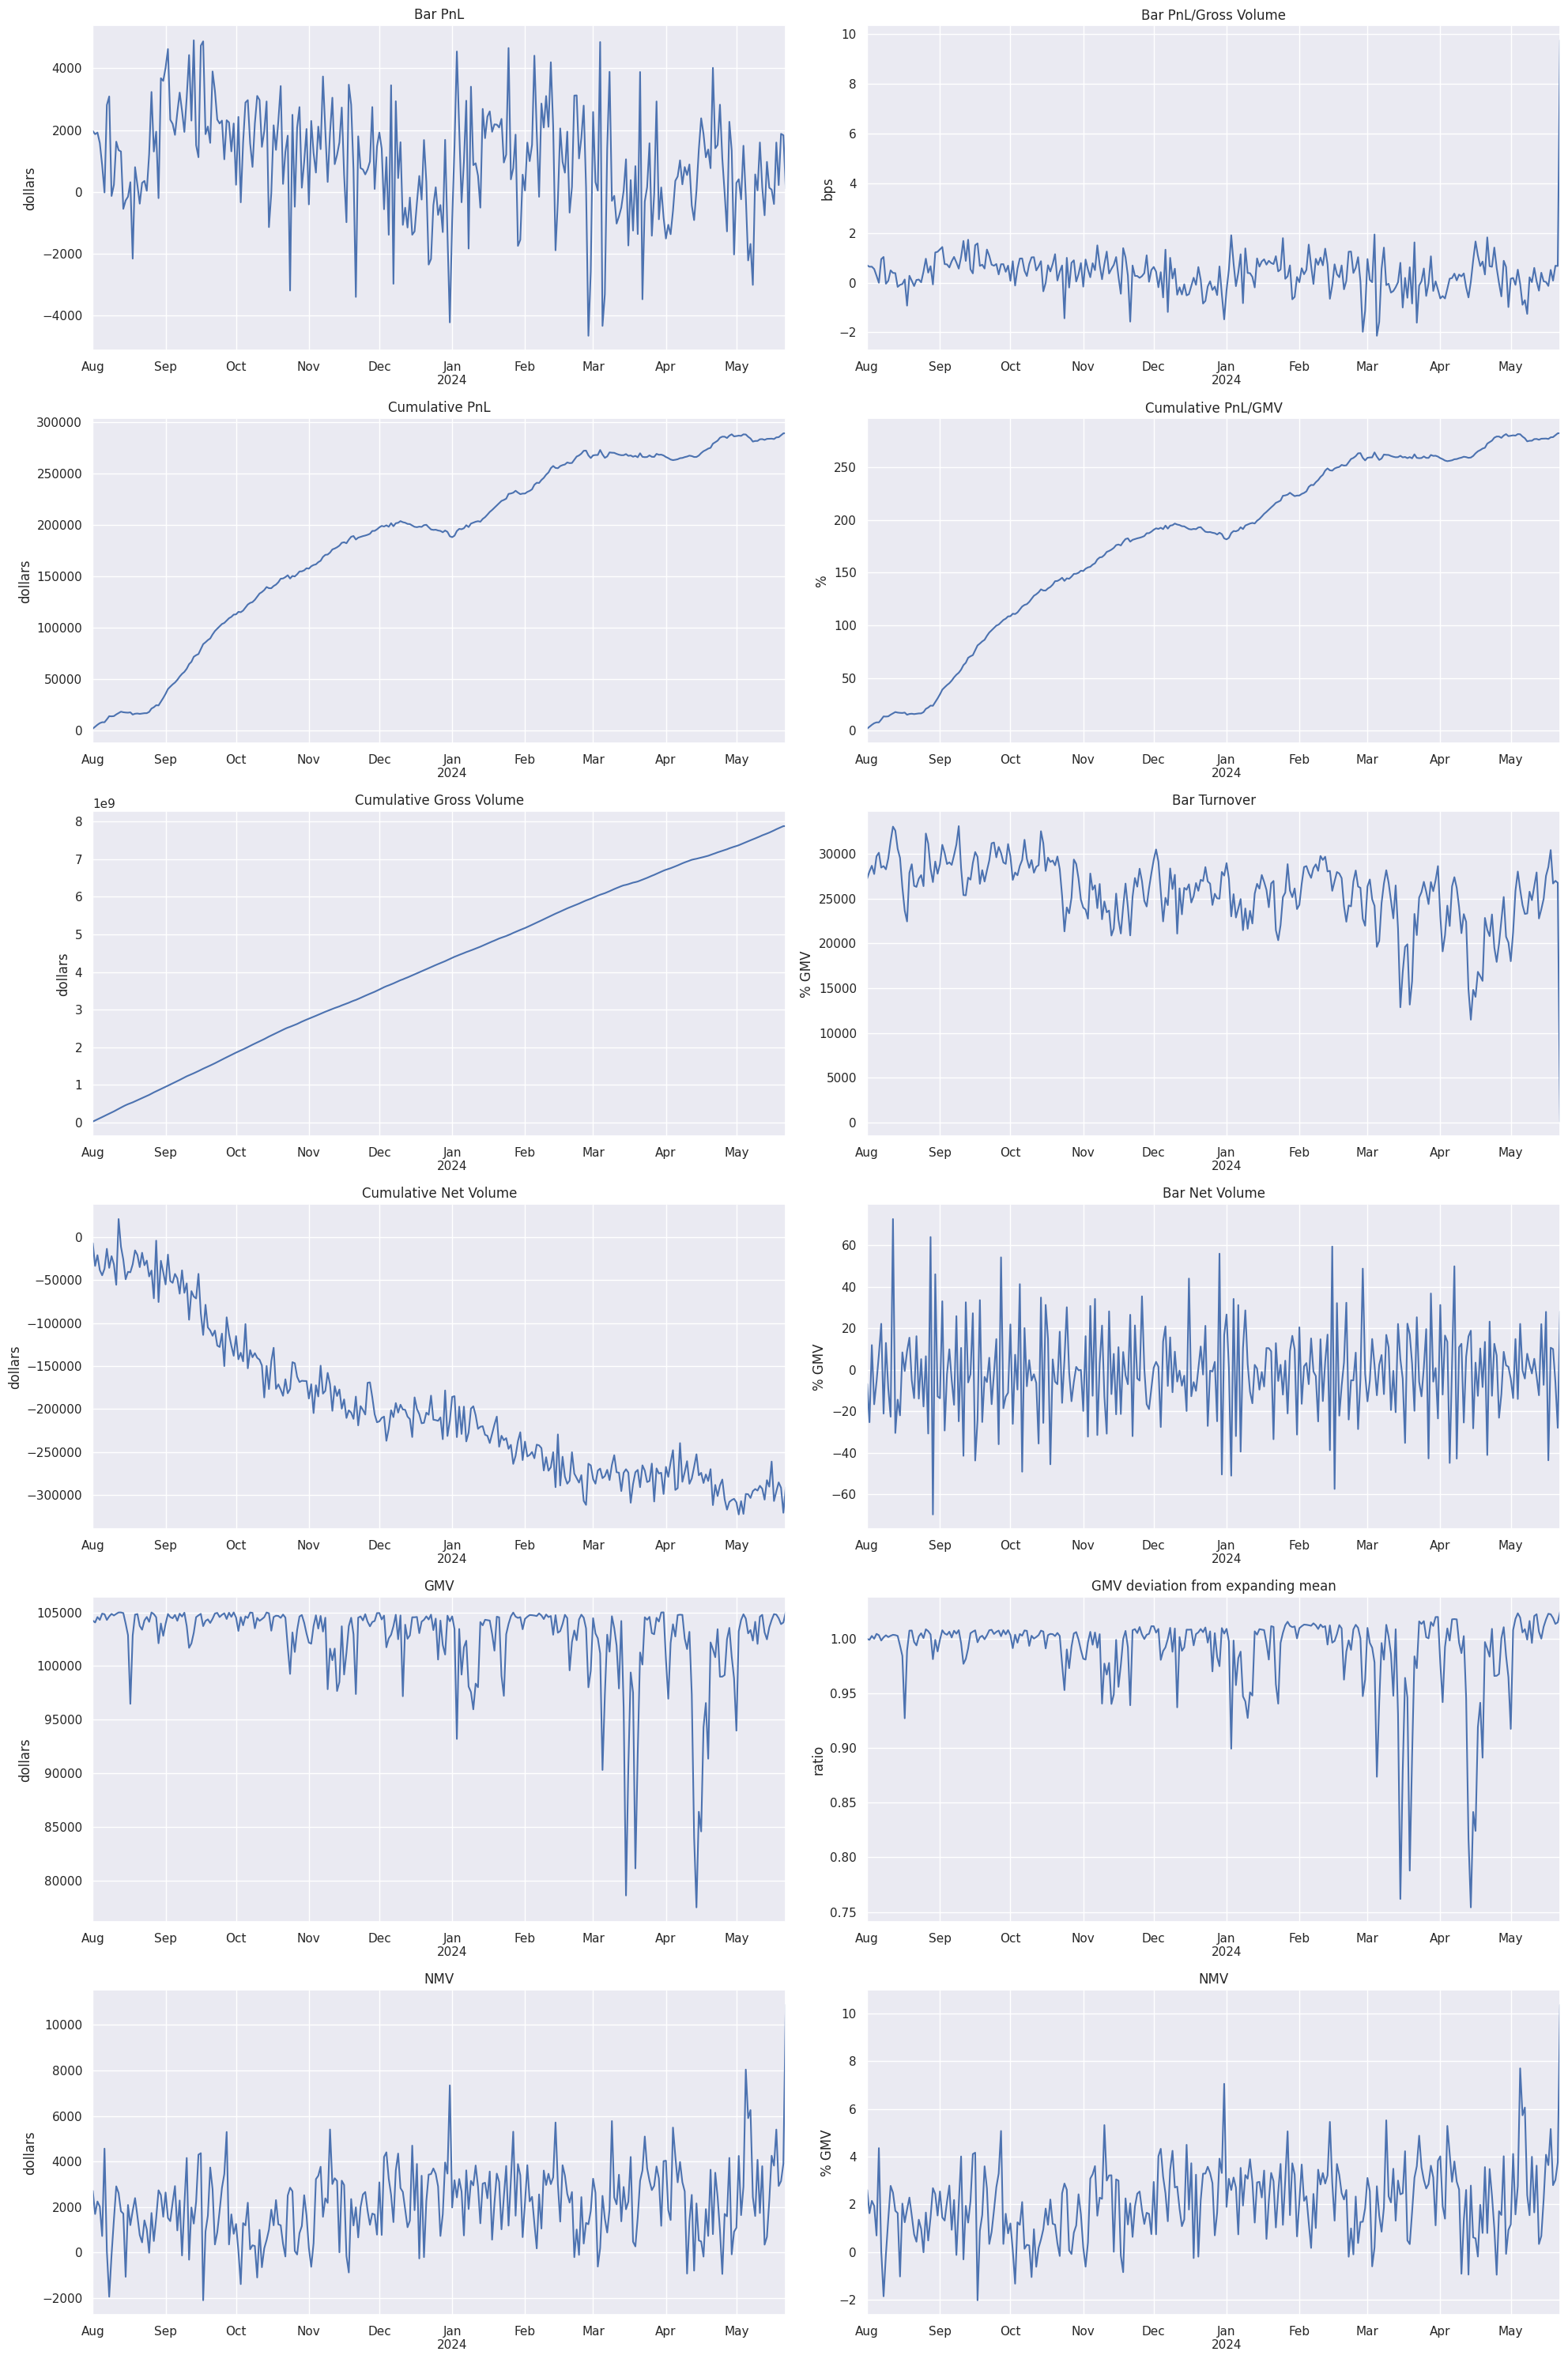

In [17]:
coplotti.plot_portfolio_stats(
    portfolio_stats_df, freq=default_config["pnl_resampling_frequency"]
)

,pnl,pnl_in_bps,sgn_corr,corr
prediction,,,,
"(-inf, -0.842]",0.216978,0.185469,0.022067,0.014772
"(-0.842, -0.253]",0.060443,0.093521,0.004876,0.003485
"(-0.253, 0.253]",0.035491,0.074336,0.002697,0.002109
"(0.253, 0.842]",0.097776,0.187888,0.010233,0.005512
"(0.842, inf]",0.440267,0.497077,0.018351,0.024346


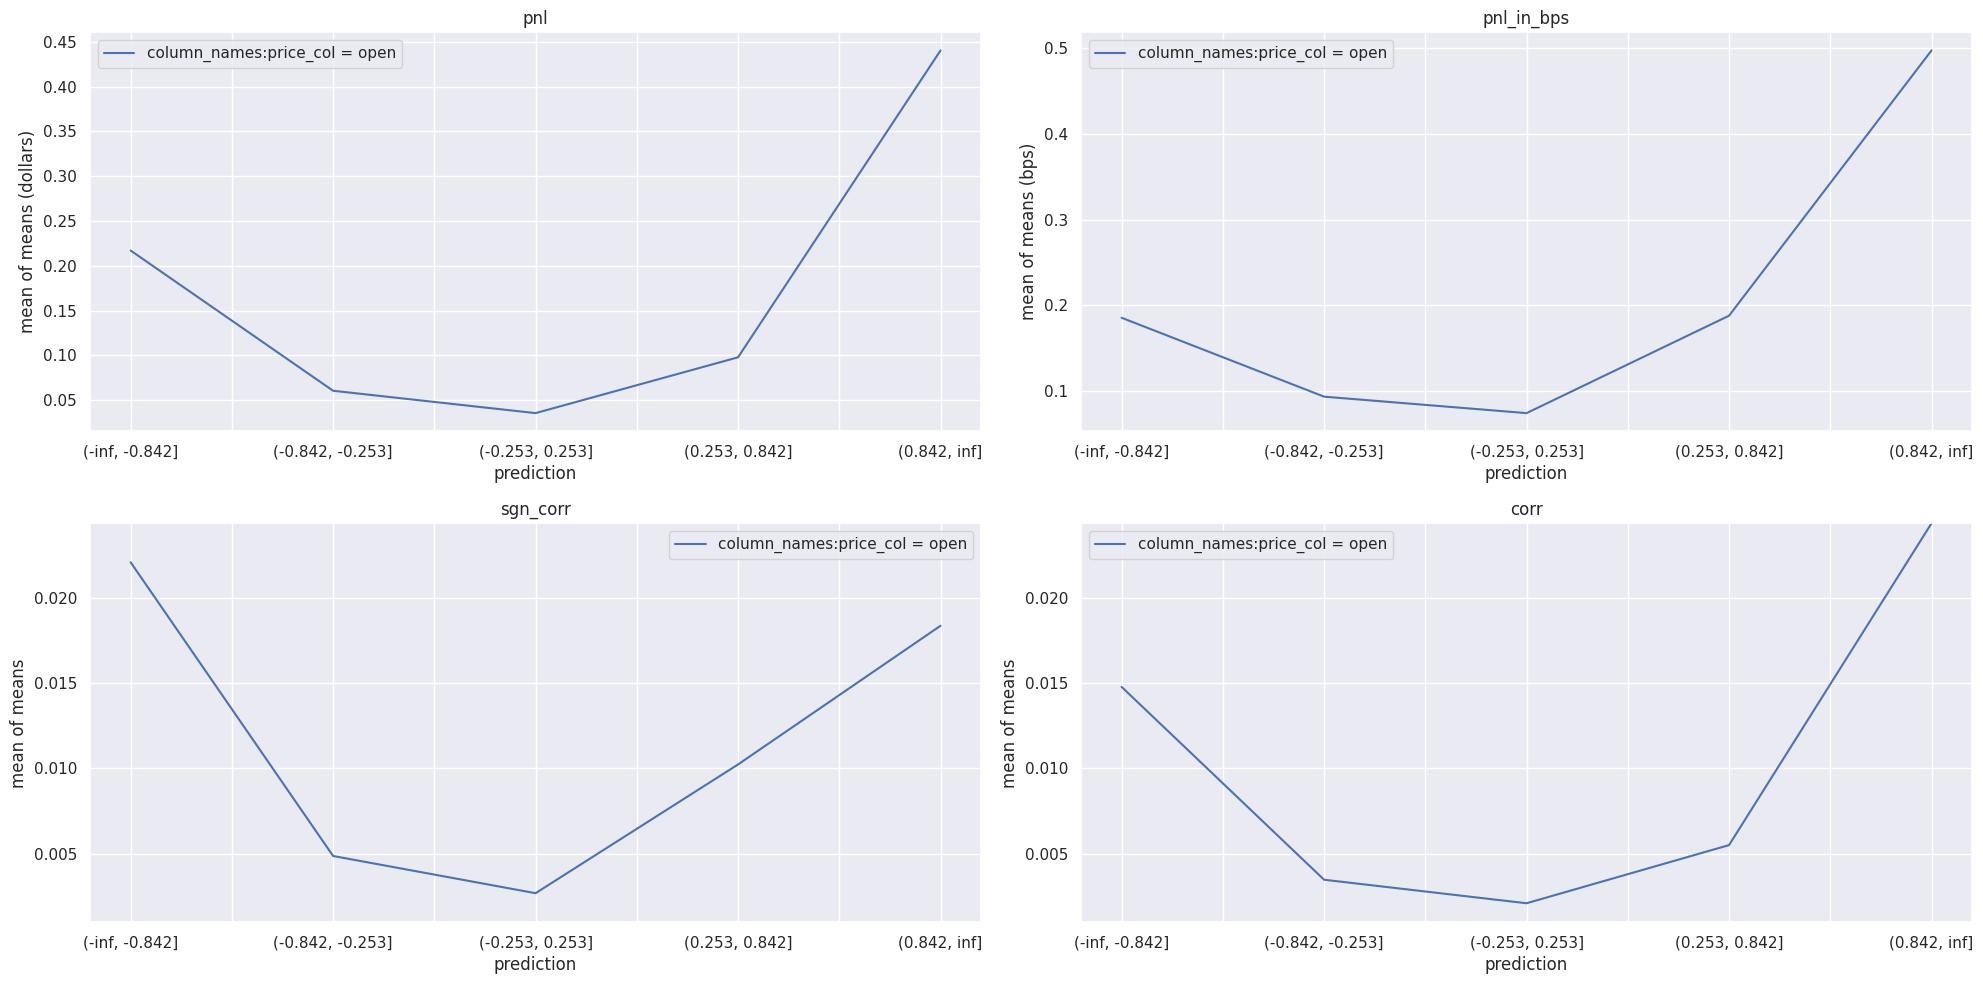

In [18]:
coplotti.plot_portfolio_binned_stats(
    portfolio_df_dict,
    **config["bin_annotated_portfolio_df_kwargs"],
)

# Compute aggregate portfolio stats

In [19]:
stats_computer = dtfmod.StatsComputer()

In [20]:
portfolio_stats, daily_metrics = stats_computer.compute_portfolio_stats(
    portfolio_stats_df,
    default_config["pnl_resampling_frequency"],
)
display(portfolio_stats)

ratios      sharpe_ratio                         10.69
            sharpe_ratio_standard_error           1.20
            sr.tval                               9.63
            sr.pval                               0.00
            kratio                                3.61
dollar      gmv_mean                         102521.59
            gmv_stdev                          4010.08
            annualized_mean_return           357256.62
            annualized_volatility             33404.56
            max_drawdown                      15661.49
            pnl_mean                            978.12
            pnl_std                            1747.88
            turnover_mean                  26607784.28
            turnover_stdev                  4151555.12
            market_bias_mean                   2151.51
            market_bias_stdev                  1645.43
percentage  annualized_mean_return              348.47
            annualized_volatility                32.58
          